# Linear thermoelasticity

The temperature field is uncoupled from the mechanical fields whereas the latter depend on the temperature due to presence of thermal strains in the thermoelastic constitutive relation. This situation can be described as *weak* thermomechanical coupling.
 

## Problem position

We consider the case of a rectangular 2D domain of dimensions $L\times H$ fully clamped on both lateral sides and the bottom side is subjected to a uniform temperature increase of $\Delta T = +50^{\circ}C$ while the top and lateral boundaries remain at the initial temperature $T_0$. The geometry and boundary regions are first defined.

In [346]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
%matplotlib inline

L, H = 5, 3
mesh = RectangleMesh(Point(0., 0.), Point(L, H), 100, 10, "crossed")

def lateral_sides(x, on_boundary):
    return (near(x[0], 0) or near(x[0], L)) and on_boundary
def bottom(x, on_boundary):
    return near(x[1], 0) and on_boundary
def top(x, on_boundary):
    return near(x[1], H) and on_boundary

Because of the weak coupling discussed before, the thermal and mechanical problem can be solved separately. As a result, we don't need to resort to Mixed FunctionSpaces but can just define separately both problems.


The temperature is solution to the following equation 
$$\text{div}(k\nabla T) = 0$$
where $k$ is the thermal conductivity (here we have no heat source). Since $k$ is assumed to be homogeneous, it will not influence the solution. We therefore obtain a standard Poisson equation without forcing terms. Its formulation and resolution in FEniCS is quite standard with the temperature variation $\Delta T$ as the main unknown.


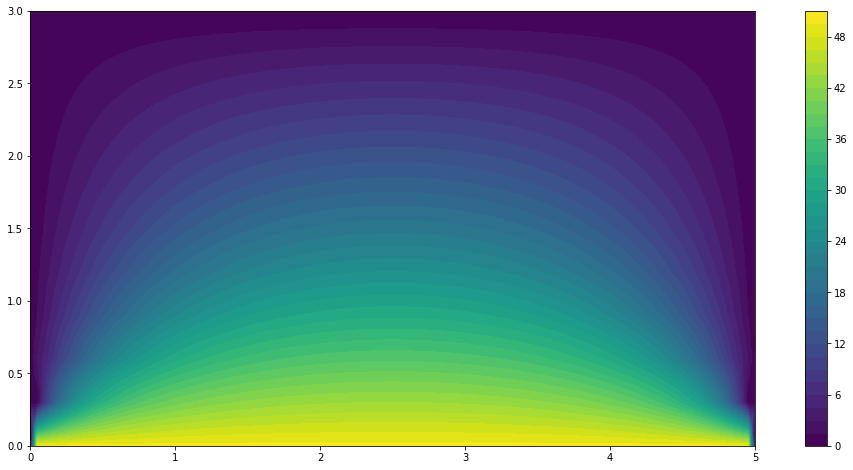

In [347]:
VT = FunctionSpace(mesh, "CG", 1)
T_, dT = TestFunction(VT), TrialFunction(VT)
Delta_T = Function(VT, name="Temperature increase")
aT = dot(grad(dT), grad(T_))*dx
LT = Constant(0)*T_*dx

bcT = [DirichletBC(VT, Constant(50.), bottom), 
       DirichletBC(VT, Constant(0.), top),
       DirichletBC(VT, Constant(0.), lateral_sides)]
solve(aT == LT, Delta_T, bcT)
plt.figure(figsize=(18, 8))
p = plot(Delta_T)
plt.colorbar(p)
plt.show()

## Mecanical problem

The linearized thermoelastic constitutive equation is given by:

$$\begin{equation}
\boldsymbol{\sigma} = \mathbb{C}:(\boldsymbol{\varepsilon}-\alpha(T-T_0)\boldsymbol{1}) = \lambda\text{tr}(\boldsymbol{\varepsilon})\boldsymbol{1}+2\mu\boldsymbol{\varepsilon} -\alpha(3\lambda+2\mu)(T-T_0)\boldsymbol{1} 
\end{equation}$$

where $\lambda,\mu$ are the Lamé parameters and $\alpha$ is the thermal expansion coefficient. As regards the current problem, the last term corresponding to the thermal strains is completely known. The following formulation can thus be generalized to any kind of known initial stress or eigenstrain state such as pre-stress or phase changes.

In [348]:
E = Constant(50e3)
nu = Constant(0.2)
mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
alpha = Constant(1e-5)

f = Constant((0, 0))

def eps(v):
    return sym(grad(v))
def sigma(v, dT):
    return (lmbda*tr(eps(v))- alpha*(3*lmbda+2*mu)*dT)*Identity(2) + 2.0*mu*eps(v)

Vu = VectorFunctionSpace(mesh, 'CG', 2)
du = TrialFunction(Vu)
u_ = TestFunction(Vu)
Wint = inner(sigma(du, Delta_T), eps(u_))*dx
aM = lhs(Wint)
LM = rhs(Wint) + inner(f, u_)*dx

bcu = DirichletBC(Vu, Constant((0., 0.)), lateral_sides)

u = Function(Vu, name="Displacement")

First, the self-weight loading is deactivated, only thermal stresses are computed.

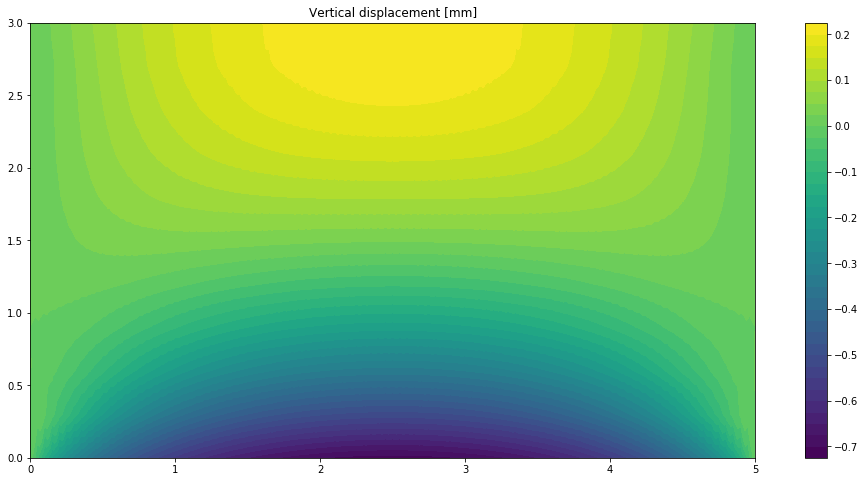

In [349]:
solve(aM == LM, u, bcu)
plt.figure(figsize=(18, 8))
p = plot(1e3*u[1],title="Vertical displacement [mm]")
plt.colorbar(p)
plt.show()

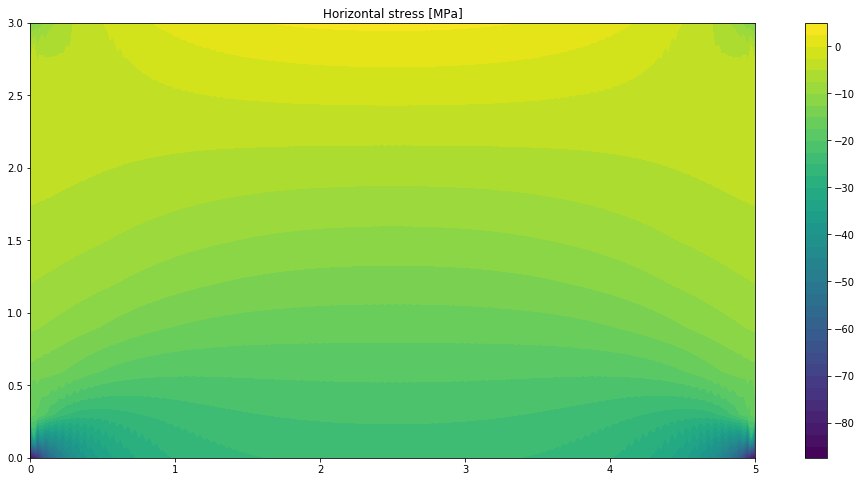

In [350]:
plt.figure(figsize=(18, 8))
p = plot(sigma(u, Delta_T)[0, 0],title="Horizontal stress [MPa]")
plt.colorbar(p)
plt.show()